In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load data

In [4]:
import causalchamber
from causalchamber.datasets import Dataset


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}



In [5]:
size='64'
to_load = [
    ('lt_camera_v1', 'uniform_ap_1.8_iso_500.0_ss_0.005'),
    ('lt_camera_v1', 'betab_ap_1.8_iso_500.0_ss_0.005'),
    ('lt_camera_walks_v1', 'ar_1_uniform_ref'),
    ('lt_camera_walks_v1', 'ar_1_uniform_pol_1_90'),
    ('lt_camera_walks_v1', 'ar_1_uniform_pol_12_30')
]

all_images = []
all_observations = []
for dset, exp in to_load:
    dataset = Dataset(dset, root='/home/juan/.chamber_datasets/', download=True)
    experiment = dataset.get_experiment(name=exp)
    observations = experiment.as_pandas_dataframe()
    images = experiment.as_image_array(size=size)
    all_images.append(images)
    all_observations.append(observations)

Dataset lt_camera_v1 found in "/home/juan/.chamber_datasets/lt_camera_v1".
Dataset lt_camera_v1 found in "/home/juan/.chamber_datasets/lt_camera_v1".
Dataset lt_camera_walks_v1 found in "/home/juan/.chamber_datasets/lt_camera_walks_v1".
Dataset lt_camera_walks_v1 found in "/home/juan/.chamber_datasets/lt_camera_walks_v1".
Dataset lt_camera_walks_v1 found in "/home/juan/.chamber_datasets/lt_camera_walks_v1".


In [6]:
all_images = np.concatenate(all_images, axis=0)

In [7]:
all_observations = pd.concat(all_observations, ignore_index=True)

## Train

In [8]:
from simulators.lt.image.decoder import DecoderNetwork
from simulators.lt.image.decoder import TorchImageDataset

In [9]:
dataset_all = TorchImageDataset(all_images, all_observations[['red', 'green', 'blue', 'pol_1', 'pol_2']].values, mean_labels=np.array([128,128,128,0,0]), std_labels=np.array([128,128,128,180,180]))
generator1 = torch.Generator().manual_seed(42)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_all, [.99, .01], generator=generator1)

In [12]:
len(dataset_train)

108900

In [11]:
def show(array):
    plt.imshow(np.transpose((array + 1)/2, (1,2,0)))

In [17]:
decoder = DecoderNetwork(device="cuda")

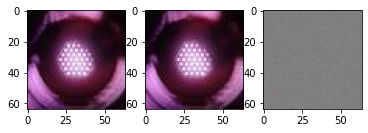

In [18]:
i = 300
x,y = dataset_all[i]
plt.subplot(131)
plt.imshow(all_images[i])
plt.subplot(132)
show(y.numpy())
plt.subplot(133)
show(decoder(x).detach().cpu().numpy())

In [19]:
train = True
if train:
    decoder.train(dataset_train, dataset_test, log_wandb="With test set", epochs=100, batch_size=4096)
else:
    decoder = DecoderNetwork(device="cuda") 
    decoder.load("../models/lt/image/torch_models/2025_01_07-15_10_26_tag_dulcet-night-9.pkl")

wandb: Currently logged in as: juangamella. Use `wandb login --relogin` to force relogin


100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


test_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.00423
train_loss,0.0044


In [24]:
decoder.save(path="sparkling-elevator-10.pkl")

Saved model DecoderNetwork(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=12288, bias=True)
  )
) to "sparkling-elevator-10.pkl"


In [29]:
x = np.array([[64,0,128,30,0], [64,0,128,30,0]])
x = (x - np.array([128,128,128,0,0])) / np.array([128,128,128,180,180])
x = torch.tensor(x, dtype=torch.float32)
output = decoder(x).detach().cpu().numpy()
output.shape

(2, 3, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


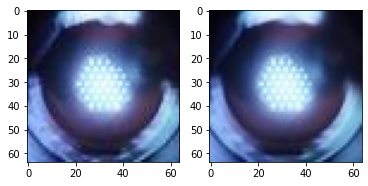

In [21]:
i = 10
x,y = dataset_test[i]
plt.subplot(121)
show(y.numpy())
plt.subplot(122)
output = decoder(x).detach().cpu().numpy()
show(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


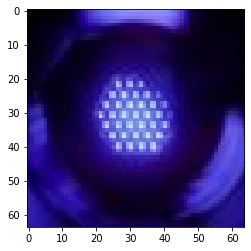

In [22]:
x = np.array([64,0,128,30,0])
x = (x - np.array([128,128,128,0,0])) / np.array([128,128,128,180,180])
x = torch.tensor(x, dtype=torch.float32)
output = decoder(x).detach().cpu().numpy()
show(output)